Dataset Shape: (28619, 3)
------------------------------
Columns: ['is_sarcastic', 'headline', 'article_link']
------------------------------
Sample Data:
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...  
------------------------------
Class Balance:
is_sarcastic
0    14985
1    13634
Name: count, 

C:\Users\aseem\AppData\Local\Temp\ipykernel_42000\3189905948.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


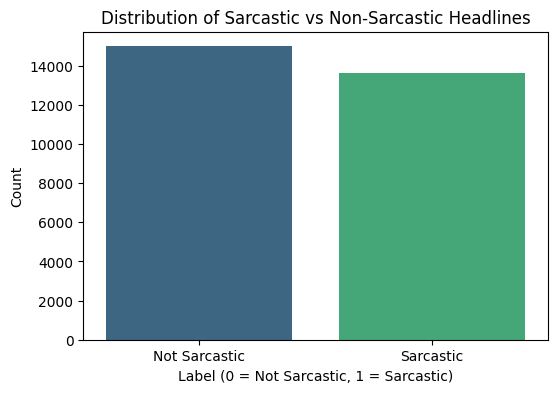

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the Dataset
df = pd.read_json(r"C:\Users\aseem\Downloads\archive\Sarcasm_Headlines_Dataset_v2.json", lines=True)

# 2. Print Basic Info
print(f"Dataset Shape: {df.shape}")
print("-" * 30)
print(f"Columns: {df.columns.tolist()}")
print("-" * 30)

# 3. View First 5 Rows
print("Sample Data:")
print(df.head())

# 4. Check Class Balance
# 1 = Sarcastic, 0 = Not Sarcastic
class_counts = df['is_sarcastic'].value_counts()
print("-" * 30)
print("Class Balance:")
print(class_counts)

# Visualizing the balance
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Sarcastic vs Non-Sarcastic Headlines')
plt.xlabel('Label (0 = Not Sarcastic, 1 = Sarcastic)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Sarcastic', 'Sarcastic'])
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
X = df['headline'].values
y = df['is_sarcastic'].values

train_texts, test_texts, train_labels, test_labels = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training samples: {len(train_texts)}")
print(f"Testing samples: {len(test_texts)}")

Training samples: 22895
Testing samples: 5724


In [14]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


train_encodings = tokenizer(
    train_texts.tolist(),
    truncation=True,
    padding=True,
    max_length=64  # Headlines are usually short, so 64 is safe
)

test_encodings = tokenizer(
    test_texts.tolist(),
    truncation=True,
    padding=True,
    max_length=64
)

# Quick check: See what the first tokenized sentence looks like
print("Example Input IDs:", train_encodings['input_ids'][0])
print("Example Attention Mask:", train_encodings['attention_mask'][0])

Example Input IDs: [101, 11734, 3237, 20057, 2039, 5896, 2008, 4269, 2007, 2996, 8154, 14059, 2046, 7411, 2915, 1997, 5025, 3137, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Example Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [15]:
import torch

class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # This function retrieves one item at index `idx`
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Initialize the dataset objects
train_dataset = SarcasmDataset(train_encodings, train_labels)
test_dataset = SarcasmDataset(test_encodings, test_labels)

print("Datasets created successfully!")

Datasets created successfully!


In [16]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Load the model with 2 labels (Sarcastic vs. Not Sarcastic)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [19]:
training_args = TrainingArguments(
    output_dir='./results',          # Where to store model checkpoints
    num_train_epochs=3,              # Total number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=100,
    eval_strategy="epoch",     # Evaluate at the end of every epoch
    save_strategy="epoch",           # Save model at the end of every epoch
    load_best_model_at_end=True      # Load the best model when finished
)

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 🚀 Start Training
print("Starting training...")
trainer.train()

Starting training...


C:\Users\aseem\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.242500,0.203917,0.918064,0.913644,0.917530,0.909791
2,0.110800,0.279408,0.925751,0.920158,0.943374,0.898056
3,0.053500,0.406639,0.925751,0.920098,0.944059,0.897323


C:\Users\aseem\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\aseem\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=4293, training_loss=0.15896965331084906, metrics={'train_runtime': 15969.9594, 'train_samples_per_second': 4.301, 'train_steps_per_second': 0.269, 'total_flos': 1137315409585920.0, 'train_loss': 0.15896965331084906, 'epoch': 3.0})

In [21]:
# Evaluate on the test set
results = trainer.evaluate()

print("-" * 30)
print("Final Evaluation Results:")
print(f"Accuracy: {results['eval_accuracy']:.4f}")
print(f"F1 Score: {results['eval_f1']:.4f}")
print("-" * 30)

# Save the model and tokenizer
model_path = "./sarcasm_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"Model saved to {model_path}")

C:\Users\aseem\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


------------------------------
Final Evaluation Results:
Accuracy: 0.9181
F1 Score: 0.9136
------------------------------
Model saved to ./sarcasm_model


In [27]:
import torch
import torch.nn.functional as F

def predict_sarcasm(text):
    # 1. Prepare the text (Tokenize)
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        truncation=True, 
        padding=True, 
        max_length=64
    )
    
    # 2. Move inputs to the same device as the model (CPU in your case)
    # If you were on GPU, you'd add .to('cuda')
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # 3. Get Model Prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 4. Convert Logits to Probabilities (Softmax)
    probs = F.softmax(outputs.logits, dim=-1)
    
    # 5. Get the label (0 or 1) and confidence score
    score = torch.max(probs).item()
    label_index = torch.argmax(probs).item()
    label = "Sarcastic" if label_index == 1 else "Not Sarcastic"
    
    return label, score

# --- TEST TIME ---
# Let's try a clearly sarcastic sentence vs. a normal one
print(predict_sarcasm("CIA Realizes It's Been Using Black Highlighters All These Years"))
print(predict_sarcasm("Winner of hot dog eating contest unfortunately also the loser"))
print(predict_sarcasm("NASA announces new mission to Mars"))

('Sarcastic', 0.9598269462585449)
('Sarcastic', 0.9765899777412415)
('Sarcastic', 0.9160128235816956)
